In [1]:
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline
# import pdb

In [2]:
import os
import os.path as op
import time
import argparse
from glob import glob
from data.data_pipe import get_val_pair
from torchvision import transforms as trans
from tqdm import tqdm_notebook as tqdm
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import logging
from IPython.display import display

from Learner import face_learner
from config import get_config
from utils import hflip_batch, cosineDim1
from data.datasets import (IJBVerificationPathDataset, IJBAVerificationDataset)
from verification import calculate_val_by_diff, calculate_val_far

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Init Learner and conf

In [4]:
conf = get_config(training=False)
conf.batch_size=20 # Why bs_size can only be the number that divide 6000 well?
learner = face_learner(conf, inference=True)

{'detachAttentionGradient': True, 'fixed_str': 'ir_se50.pth', 'pretrainedMdl': 'ir_se50.pth', 'data_path': PosixPath('data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('work_space/save'), 'exp_title': 'xCos', 'exp_comment': 'expMS1M_detached', 'input_size': [112, 112], 'embedding_size': 1568, 'use_mobilfacenet': False, 'modelType': 'ArcFace', 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda', index=0), 'test_transform': Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'data_mode': 'emore', 'vgg_folder': PosixPath('data/faces_vgg_112x112'), 'ms1m_folder': PosixPath('data/faces_ms1m_112x112'), 'emore_folder': PosixPath('data/faces_emore'), 'batch_size': 20, 'USE_SOFTMAX': True, 'SOFTMAX_T': 1, 'facebank_path': PosixPath('data/facebank'), 'threshold': 1.5, 'threshold_xCos': 0.2338, 'face_limit': 10, 'min_face_size'

In [5]:
def l2normalize(x, ord=2, axis=None):
    return x / np.linalg.norm(x, ord=ord, axis=axis)


def score_fn_original(feat1, feat2):
    return l2normalize(feat1).dot(l2normalize(feat2))
    

def score_fn_ours(feat_map1, feat_map2, learner, attention_strategy='learned', attention_weight=None):
    with torch.no_grad():
        assert len(feat_map1.shape) == 3  # [c, w, h]
        c, w, h = feat_map1.shape
        feat_map1 = torch.tensor(feat_map1).unsqueeze(0).to(conf.device)
        feat_map2 = torch.tensor(feat_map2).unsqueeze(0).to(conf.device)
        if attention_strategy == 'learned':
            attention = None
        elif attention_strategy == 'uniform':
            learner.model_attention.eval()
            attention = torch.ones([1, 1, w, h])  # [batch, c, w, h]
            attention /= attention.sum()
            attention = attention.to(conf.device)
        elif attention_strategy == 'fixed':
            assert attention_weight is not None
            assert attention_weight.shape[0] == w and attention_weight.shape[1] == h
            attention = torch.tensor(attention_weight).view(
                [1, 1, attention_weight.shape[0], attention_weight.shape[1]]
            ).type(feat_map1.type())
        else:
            raise NotImplementedError
        xCos, attention, cos_patched = learner.get_x_cosine(feat_map1, feat_map2, attention)
    return xCos.cpu().numpy()

def evaluate_and_plot(scores, is_sames, logger, nrof_folds=10, 
                      dataset_name='AR Face', display_roc_curve=True):
    accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(scores, is_sames, nrof_folds=10)
    message = f'{dataset_name} - accuray:{accuracy:.5f} (1-{1-accuracy:.5f}), threshold:{best_threshold}'
    print(message)
    logger.info(message)
    #with open(log_filename, 'a') as f:
    #    f.write(message + '\n')
    if display_roc_curve:
        roc_img = trans.ToPILImage()(roc_curve_tensor)
        display(roc_img)
        # roc_img.save(log_filename[:-4] + '.png')
        roc_img.save(logger.handlers[0].baseFilename[:-4] + '.png')
    return accuracy

# Evaluate on IJB-B

In [6]:
IJB_B_or_C = 'IJBB' # 'IJBC'
leave_ratio = 1
ijb_feat_root=f'work_space/IJB_features/{IJB_B_or_C}_ir_se50/',
loader = torch.utils.data.DataLoader(
    IJBVerificationPathDataset(ijb_dataset_root=f'data/IJB_release/{IJB_B_or_C}/', 
                               dataset_type=IJB_B_or_C,
                               leave_ratio=leave_ratio),
    batch_size=1, shuffle=False
)
len(loader)

8010270

In [7]:
def _get_feature_original(feat_dir, suffixes, ends_with='.npy'):
    return np.concatenate([
        np.load(op.join(feat_dir, suffix[0]) + ends_with)
        for suffix in suffixes
    ], axis=0)

def _get_feature_ours(feat_dir, suffixes, ends_with='.npz'):
#     print(op.join(feat_dir, suffixes[0][0]) + ends_with)
    return np.concatenate([
        np.load(op.join(feat_dir, suffix[0]) + ends_with)['feat_map']
        for suffix in suffixes
    ], axis=0)


def run_IJBC_verification(loader, feat_dir, compare_strategy, _get_feature, 
                          score_fn, score_fn_kargs,
                          logger,
                          learner=None, attention_strategy=None):
    assert compare_strategy in ['compare_only_first_img', 'mean_comparison']
    is_sames = []
    scores = []
    init_time = time.time()
    ignored_count = 0
    tmp_same_count = 0
    # with open(log_filename, 'w') as f:
    msg_total = f"total number: {len(loader)}"
    print(msg_total)
    # f.write(msg_total + '\n')
    logger.info(msg_total)
    for i, pair in enumerate(loader):
        if i % 10000 == 0:
            msg = (f"Processing match {i}, elapsed {time.time() - init_time:.1f}\
            seconds, positive ratio: {tmp_same_count / (i+1):.4f}")
            print(msg)
            # f.write(msg + '\n')
            logger.info(msg)

        if len(pair['enroll_path_suffixes']) == 0 or len(pair['verif_path_suffixes']) == 0:
            ignored_count += 1
            continue

        if compare_strategy == 'compare_only_first_img':
            enroll_feature = _get_feature(feat_dir, pair['enroll_path_suffixes'][:1]).squeeze(0)
            verif_feature = _get_feature(feat_dir, pair['verif_path_suffixes'][:1]).squeeze(0)
        elif compare_strategy == 'mean_comparison':
            print('Warning: using mean_comparison')
            raise NotImplementedError
            enroll_feature = _get_feature(feat_dir, pair['enroll_path_suffixes']).mean(axis=0)
            verif_feature = _get_feature(feat_dir, pair['verif_path_suffixes']).mean(axis=0)
        else:
            raise NotImplementedError
        score = score_fn(enroll_feature, verif_feature, **score_fn_kargs)
        scores.append(score)
        # XXX: Why is pair['is_same'] a list?
        # if bool(int(pair['is_same'][0])):
        #     print((int(pair['is_same'][0])))
        #     print('    >>>', bool(int(pair['is_same'][0])))
        #     print(pair)
        is_same_label = bool(int(pair['is_same'][0]))
        is_sames.append(is_same_label)
        if is_same_label:
            tmp_same_count += 1
    msg_ignored = f'{ignored_count} pairs are ignored since one of the template has no valid image.'
    print(msg_ignored)
    #f.write(msg_ignored + '\n')
    logger.info(msg_ignored)
    ############
    scores = np.array(scores).squeeze()
    is_sames = np.array(is_sames).squeeze().astype(np.bool)
    np.savetxt(f"{logger.handlers[0].baseFilename[:-4]}_scores.csv", scores, delimiter=",")
    np.savetxt(f"{logger.handlers[0].baseFilename[:-4]}_is_sames.csv", is_sames, delimiter=",")
    return scores, is_sames

In [8]:
all_scores = {}
all_acc = {}

def record_scores_and_acc(scores, acc, name, name2=None):
    all_scores[name] = scores
    all_acc[name] = acc

## Run irse-50 model

total number: 8010270
Processing match 0, elapsed 0.0            seconds, positive ratio: 0.0000
Processing match 10000, elapsed 7.5            seconds, positive ratio: 0.9999
Processing match 20000, elapsed 14.2            seconds, positive ratio: 0.5135
Processing match 30000, elapsed 20.9            seconds, positive ratio: 0.3423
Processing match 40000, elapsed 27.7            seconds, positive ratio: 0.2567
Processing match 50000, elapsed 34.4            seconds, positive ratio: 0.2054
Processing match 60000, elapsed 41.1            seconds, positive ratio: 0.1712
Processing match 70000, elapsed 47.8            seconds, positive ratio: 0.1467
Processing match 80000, elapsed 54.5            seconds, positive ratio: 0.1284
Processing match 90000, elapsed 61.2            seconds, positive ratio: 0.1141
Processing match 100000, elapsed 67.9            seconds, positive ratio: 0.1027
Processing match 110000, elapsed 74.6            seconds, positive ratio: 0.0934
Processing match 12000

Processing match 1010000, elapsed 683.0            seconds, positive ratio: 0.0102
Processing match 1020000, elapsed 689.7            seconds, positive ratio: 0.0101
Processing match 1030000, elapsed 696.4            seconds, positive ratio: 0.0100
Processing match 1040000, elapsed 703.1            seconds, positive ratio: 0.0099
Processing match 1050000, elapsed 709.8            seconds, positive ratio: 0.0098
Processing match 1060000, elapsed 716.5            seconds, positive ratio: 0.0097
Processing match 1070000, elapsed 723.2            seconds, positive ratio: 0.0096
Processing match 1080000, elapsed 729.9            seconds, positive ratio: 0.0095
Processing match 1090000, elapsed 736.6            seconds, positive ratio: 0.0094
Processing match 1100000, elapsed 743.3            seconds, positive ratio: 0.0093
Processing match 1110000, elapsed 750.0            seconds, positive ratio: 0.0093
Processing match 1120000, elapsed 756.7            seconds, positive ratio: 0.0092
Proc

Processing match 2000000, elapsed 1348.7            seconds, positive ratio: 0.0051
Processing match 2010000, elapsed 1355.4            seconds, positive ratio: 0.0051
Processing match 2020000, elapsed 1362.3            seconds, positive ratio: 0.0051
Processing match 2030000, elapsed 1369.2            seconds, positive ratio: 0.0051
Processing match 2040000, elapsed 1376.1            seconds, positive ratio: 0.0050
Processing match 2050000, elapsed 1383.0            seconds, positive ratio: 0.0050
Processing match 2060000, elapsed 1389.8            seconds, positive ratio: 0.0050
Processing match 2070000, elapsed 1396.7            seconds, positive ratio: 0.0050
Processing match 2080000, elapsed 1403.6            seconds, positive ratio: 0.0049
Processing match 2090000, elapsed 1410.5            seconds, positive ratio: 0.0049
Processing match 2100000, elapsed 1417.4            seconds, positive ratio: 0.0049
Processing match 2110000, elapsed 1424.3            seconds, positive ratio:

Processing match 2980000, elapsed 2013.9            seconds, positive ratio: 0.0034
Processing match 2990000, elapsed 2020.6            seconds, positive ratio: 0.0034
Processing match 3000000, elapsed 2027.3            seconds, positive ratio: 0.0034
Processing match 3010000, elapsed 2034.0            seconds, positive ratio: 0.0034
Processing match 3020000, elapsed 2040.7            seconds, positive ratio: 0.0034
Processing match 3030000, elapsed 2047.4            seconds, positive ratio: 0.0034
Processing match 3040000, elapsed 2054.1            seconds, positive ratio: 0.0034
Processing match 3050000, elapsed 2060.8            seconds, positive ratio: 0.0034
Processing match 3060000, elapsed 2067.5            seconds, positive ratio: 0.0034
Processing match 3070000, elapsed 2074.2            seconds, positive ratio: 0.0033
Processing match 3080000, elapsed 2080.9            seconds, positive ratio: 0.0033
Processing match 3090000, elapsed 2087.6            seconds, positive ratio:

Processing match 3960000, elapsed 2675.5            seconds, positive ratio: 0.0026
Processing match 3970000, elapsed 2682.2            seconds, positive ratio: 0.0026
Processing match 3980000, elapsed 2688.9            seconds, positive ratio: 0.0026
Processing match 3990000, elapsed 2695.6            seconds, positive ratio: 0.0026
Processing match 4000000, elapsed 2702.3            seconds, positive ratio: 0.0026
Processing match 4010000, elapsed 2709.0            seconds, positive ratio: 0.0026
Processing match 4020000, elapsed 2715.7            seconds, positive ratio: 0.0026
Processing match 4030000, elapsed 2722.4            seconds, positive ratio: 0.0025
Processing match 4040000, elapsed 2729.2            seconds, positive ratio: 0.0025
Processing match 4050000, elapsed 2736.0            seconds, positive ratio: 0.0025
Processing match 4060000, elapsed 2742.7            seconds, positive ratio: 0.0025
Processing match 4070000, elapsed 2749.4            seconds, positive ratio:

Processing match 4940000, elapsed 3334.2            seconds, positive ratio: 0.0021
Processing match 4950000, elapsed 3340.9            seconds, positive ratio: 0.0021
Processing match 4960000, elapsed 3347.6            seconds, positive ratio: 0.0021
Processing match 4970000, elapsed 3354.3            seconds, positive ratio: 0.0021
Processing match 4980000, elapsed 3361.0            seconds, positive ratio: 0.0021
Processing match 4990000, elapsed 3367.7            seconds, positive ratio: 0.0021
Processing match 5000000, elapsed 3374.4            seconds, positive ratio: 0.0021
Processing match 5010000, elapsed 3381.1            seconds, positive ratio: 0.0020
Processing match 5020000, elapsed 3387.7            seconds, positive ratio: 0.0020
Processing match 5030000, elapsed 3394.4            seconds, positive ratio: 0.0020
Processing match 5040000, elapsed 3401.1            seconds, positive ratio: 0.0020
Processing match 5050000, elapsed 3407.8            seconds, positive ratio:

Processing match 5920000, elapsed 3990.2            seconds, positive ratio: 0.0017
Processing match 5930000, elapsed 3996.9            seconds, positive ratio: 0.0017
Processing match 5940000, elapsed 4003.6            seconds, positive ratio: 0.0017
Processing match 5950000, elapsed 4010.3            seconds, positive ratio: 0.0017
Processing match 5960000, elapsed 4017.0            seconds, positive ratio: 0.0017
Processing match 5970000, elapsed 4023.7            seconds, positive ratio: 0.0017
Processing match 5980000, elapsed 4030.4            seconds, positive ratio: 0.0017
Processing match 5990000, elapsed 4037.1            seconds, positive ratio: 0.0017
Processing match 6000000, elapsed 4043.8            seconds, positive ratio: 0.0017
Processing match 6010000, elapsed 4050.5            seconds, positive ratio: 0.0017
Processing match 6020000, elapsed 4057.2            seconds, positive ratio: 0.0017
Processing match 6030000, elapsed 4063.9            seconds, positive ratio:

Processing match 6900000, elapsed 4646.3            seconds, positive ratio: 0.0015
Processing match 6910000, elapsed 4653.0            seconds, positive ratio: 0.0015
Processing match 6920000, elapsed 4659.7            seconds, positive ratio: 0.0015
Processing match 6930000, elapsed 4666.4            seconds, positive ratio: 0.0015
Processing match 6940000, elapsed 4673.1            seconds, positive ratio: 0.0015
Processing match 6950000, elapsed 4679.8            seconds, positive ratio: 0.0015
Processing match 6960000, elapsed 4686.5            seconds, positive ratio: 0.0015
Processing match 6970000, elapsed 4693.2            seconds, positive ratio: 0.0015
Processing match 6980000, elapsed 4699.9            seconds, positive ratio: 0.0015
Processing match 6990000, elapsed 4706.5            seconds, positive ratio: 0.0015
Processing match 7000000, elapsed 4713.2            seconds, positive ratio: 0.0015
Processing match 7010000, elapsed 4719.9            seconds, positive ratio:

Processing match 7880000, elapsed 5305.4            seconds, positive ratio: 0.0013
Processing match 7890000, elapsed 5312.1            seconds, positive ratio: 0.0013
Processing match 7900000, elapsed 5318.8            seconds, positive ratio: 0.0013
Processing match 7910000, elapsed 5325.5            seconds, positive ratio: 0.0013
Processing match 7920000, elapsed 5332.2            seconds, positive ratio: 0.0013
Processing match 7930000, elapsed 5338.9            seconds, positive ratio: 0.0013
Processing match 7940000, elapsed 5345.6            seconds, positive ratio: 0.0013
Processing match 7950000, elapsed 5352.3            seconds, positive ratio: 0.0013
Processing match 7960000, elapsed 5359.0            seconds, positive ratio: 0.0013
Processing match 7970000, elapsed 5365.7            seconds, positive ratio: 0.0013
Processing match 7980000, elapsed 5372.4            seconds, positive ratio: 0.0013
Processing match 7990000, elapsed 5379.1            seconds, positive ratio:

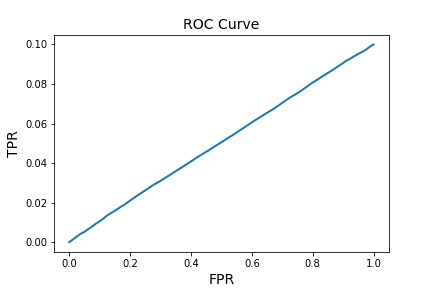

In [9]:
model_name = f'{IJB_B_or_C}_ir_se50'
log_filename = f"logs/Log_{model_name}.txt"
logging.basicConfig(filename=log_filename, level=logging.INFO)
logger = logging.getLogger()
scores, is_sames = run_IJBC_verification(
    loader, feat_dir=f'work_space/IJB_features/{model_name}/loose_crop/',
    score_fn=score_fn_original, _get_feature=_get_feature_original,
    compare_strategy='compare_only_first_img', score_fn_kargs={},
    logger=logger,
)
acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name=model_name, 
                        logger=logger)
all_scores['original_ArcFace'] = scores
all_acc['original_ArcFace'] = acc

## Run CosFace model

In [ ]:
model_name = '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace'
fixed_weight = np.load(f'data/correlation_weights/{model_name}.npy')
fixed_weight /= fixed_weight.sum()

for attention_strategy in ['uniform', 'learned', 'fixed']:
    print(f'===== attention_strategy: {attention_strategy} =====')
    log_filename = f"logs/Log_{IJB_B_or_C}_{model_name}_{attention_strategy}.txt"
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=log_filename, level=logging.DEBUG)
    logger = logging.getLogger()
    scores, is_sames = run_IJBC_verification(
        loader, feat_dir=f"work_space/IJB_features/{IJB_B_or_C}_{model_name}/loose_crop",
        score_fn=score_fn_ours, _get_feature=_get_feature_ours,
        compare_strategy='compare_only_first_img',
        score_fn_kargs={'learner': learner, 'attention_strategy': attention_strategy,
                        'attention_weight': fixed_weight},
        logger = logger
    )
    acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name=f"{IJB_B_or_C}_{model_name}",
                            logger=logger)

    all_scores[f'{model_name}_{attention_strategy}'] = scores
    all_acc[f'{model_name}_{attention_strategy}'] = acc

In [ ]:
all_scores

In [ ]:
all_acc

## Run ArcFace model

In [ ]:
model_name = '2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None'
fixed_weight = np.load(f'data/correlation_weights/{model_name}.npy')
fixed_weight /= fixed_weight.sum()

for attention_strategy in ['uniform', 'learned', 'fixed']:
    print(f'===== attention_strategy: {attention_strategy} =====')
    log_filename = f"logs/Log_{IJB_B_or_C}_{model_name}_{attention_strategy}.txt"
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=log_filename, level=logging.DEBUG)
    logger = logging.getLogger()
    scores, is_sames = run_IJBC_verification(
        loader, feat_dir=f"work_space/IJB_features/{IJB_B_or_C}_{model_name}/loose_crop",
        score_fn=score_fn_ours, _get_feature=_get_feature_ours,
        compare_strategy='compare_only_first_img',
        score_fn_kargs={'learner': learner, 'attention_strategy': attention_strategy,
                        'attention_weight': fixed_weight},
        logger = logger
    )
    acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name=f"{IJB_B_or_C}_{model_name}",
                            logger=logger)

    all_scores[f'{model_name}_{attention_strategy}'] = scores
    all_acc[f'{model_name}_{attention_strategy}'] = acc

In [ ]:
input()

# IJB-A

In [ ]:
all_scores = {}
all_acc = {}

def record_scores_and_acc(scores, acc, name, name2=None):
    all_scores[name] = scores
    all_acc[name] = acc
    
shuffle_order = np.arange(len(IJBAVerificationDataset()))
np.random.shuffle(shuffle_order)

In [ ]:
'''
For IJB-A, I save features of t1 and t2 "for each comparison" and the corresponding label (is same or not)
'''
def _get_feature(fname):
    npz = np.load(fname)
    return npz['f1'], npz['f2'], npz['same']

def run_IJBA_verification(feat_dir, score_fn, score_fn_kargs, shuffle_order,
                          learner=None, attention_strategy=None, ):
    is_sames = []
    scores = []
    init_time = time.time()
    fnames = sorted(glob(op.join(feat_dir, '*.npz')))
    fnames = [fnames[i] for i in shuffle_order]
    print(len(fnames))
    for i, fname in enumerate(fnames):
        if i % 500 == 0:
            print(f"Processing match {i}, elapsed {time.time() - init_time:.1f} seconds")
        f1, f2, is_same = _get_feature(fname)
        score = score_fn(f1, f2, **score_fn_kargs)
        score = score.cpu().numpy() if torch.is_tensor(score) else score
        scores.append(score)
        is_sames.append(is_same.astype(np.bool))
    
    scores = np.array(scores).squeeze()
    is_sames = np.array(is_sames).squeeze().astype(np.bool)
    return scores, is_sames

In [ ]:
scores, is_sames = run_IJBA_verification(
    feat_dir='./saved_features/IJB-A/split1/ir_se50/',
    score_fn=score_fn_original, score_fn_kargs={},
    shuffle_order=shuffle_order
)
print(np.histogram(scores), np.histogram(is_sames))
acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')
all_scores['original_ArcFace'] = scores
all_acc['original_ArcFace'] = acc

In [ ]:
for far_target in [1e-1, 1e-2, 1e-3]:
    mean_tar = calculate_val_by_diff(
        thresholds='default', dist=(1 - scores), actual_issame=is_sames, far_target=0.001, ret_acc=True,
        nrof_folds=5
    )[0]
    print("TAR@FAR{far_target:.f}:{mean_tar}")
# calculate_val_far()

In [ ]:
evaluate_and_plot_roc

In [ ]:
model_name = '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace'
fixed_weight = np.load(f'/tmp3/biolin/data/insightFace_pytorch/{model_name}.npy')
fixed_weight /= fixed_weight.sum()

for attention_strategy in ['uniform', 'learned', 'fixed']:
    print(f'===== attention_strategy: {attention_strategy} =====')
    scores, is_sames = run_IJBA_verification(
        feat_dir=f'./saved_features/IJB-A/split1/{model_name}',
        score_fn=score_fn_ours,
        score_fn_kargs={'learner': learner, 'attention_strategy': attention_strategy,
                        'attention_weight': fixed_weight},
        shuffle_order=shuffle_order
    )
    acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')

    all_scores[f'{model_name}_{attention_strategy}'] = scores
    all_acc[f'{model_name}_{attention_strategy}'] = acc

# The following codes are just testing
## Evaluate on LFW (just testing)

In [ ]:
def getUnitAttention():
    x = torch.ones(conf.batch_size//2, 1, 7, 7).cuda()
    x /= x.flatten(2).sum(dim=2).repeat(1, 1, x.size(2) * x.size(3)).view_as(x)
    return x
unit_attention = getUnitAttention()
unit_attention.size()

In [ ]:
lfw, lfw_issame = get_val_pair(conf.emore_folder, 'lfw')
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)
learner.model.eval()
learner.model.returnGrid = True  # Remember to reset this before return!
learner.model_attention.eval()

## Our models (wo/w attention)

In [ ]:
# %%time
# accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
#     conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=unit_attention
# )
# print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
# trans.ToPILImage()(roc_curve_tensor)

In [ ]:
# %%time
# accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
#     conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=None
# )
# print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
# trans.ToPILImage()(roc_curve_tensor)

## The original model

In [ ]:
%%time
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)
cosines = learner.get_original_cosines(lfw, conf, tta=True)
accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(cosines, lfw_issame, nrof_folds=10)
print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
trans.ToPILImage()(roc_curve_tensor)

In [ ]:
calculate_val_by_diff(
    thresholds='default', dist=(1 - cosines), actual_issame=lfw_issame,
    far_target=0.001, ret_acc=True)

In [ ]:
calculate_val_far((1 - 0.28250000000000103), (1 - cosines), lfw_issame, ret_acc=True)